# Forecasting Bike Rentals in NYC

Our goal is to forecast the number of bike rides in New York City in a given day. We aim to investigate weather and seasonality effects on bike ridership. 

Datasets used:
1.   [Citi Bike System Data ](https://www.citibikenyc.com/system-data)
2.   [NOAA Weather data](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt)



 ## Setup

In [ ]:
from datetime import datetime, timedelta
from google.colab import drive
from prettytable import PrettyTable
from sklearn import metrics
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error
from sklearn.metrics import precision_score, accuracy_score, classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import graphviz
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import pydot
import seaborn as sns

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


## Load data

**Read weather data from NOOA dataset**

In [ ]:
path = '/content/drive/My Drive/cmpe-255 - Data Mining/nooa_nyc_weather_features.csv'
weather_features = pd.read_csv(path)
weather_features['Date'] = pd.to_datetime(weather_features['Date'], infer_datetime_format=True)
weather_features

,Date,TMAX,TMIN,PRCP,SNOW,AWND,SNWD,WDF2,WDF5,WSF2,WSF5
0,2015-01-01,39.0,-27.0,0.0,0.0,32.0,0.0,260.0,250.0,76.0,139.0
1,2015-01-02,56.0,17.0,0.0,0.0,32.0,0.0,260.0,310.0,67.0,112.0
2,2015-01-03,56.0,6.0,180.0,0.0,29.0,0.0,80.0,70.0,54.0,81.0
3,2015-01-04,133.0,50.0,76.0,0.0,29.0,0.0,280.0,260.0,130.0,206.0
4,2015-01-05,94.0,-60.0,0.0,0.0,47.0,0.0,280.0,300.0,107.0,170.0
...,...,...,...,...,...,...,...,...,...,...,...
2096,2020-09-27,261.0,194.0,8.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN
2097,2020-09-28,250.0,206.0,5.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN
2098,2020-09-29,233.0,194.0,119.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN
2099,2020-09-30,217.0,156.0,290.0,0.0,28.0,0.0,270.0,160.0,76.0,121.0


**Read aggregated ride count**

In [ ]:
rides_tmp = []
years = range(2013, 2021)
for y in years:
  path = '/content/drive/My Drive/cmpe-255 - Data Mining/citibikes/rides_count_agg_{}.csv'.format(y)
  rides_y = pd.read_csv(path)
  rides_tmp.append(rides_y)

rides = pd.concat(rides_tmp)
rides['date'] = pd.to_datetime(rides['date'], infer_datetime_format=True)
rides = rides[rides.date < '2020-03-01']
rides.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4442 entries, 0 to 119
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      4442 non-null   datetime64[ns]
 1   usertype  4442 non-null   object        
 2   numrides  4442 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 138.8+ KB


## Data preprocessing

**Missing value analysis of weather data**


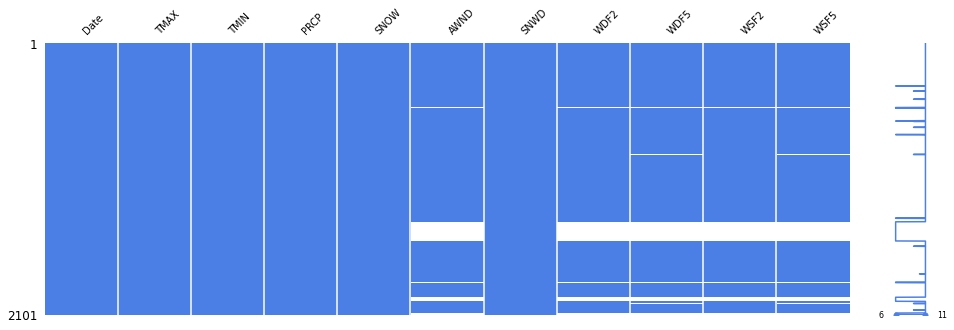

In [ ]:
msno.matrix(weather_features, figsize=(16,5), fontsize=10, color=(0.3,0.5,0.9)) 


**Outlier analysis of weather data**

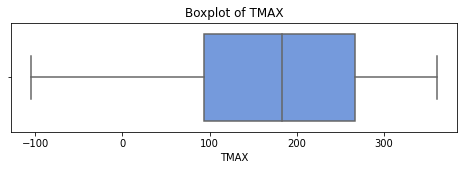

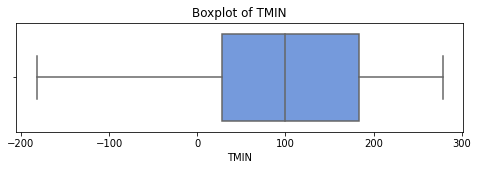

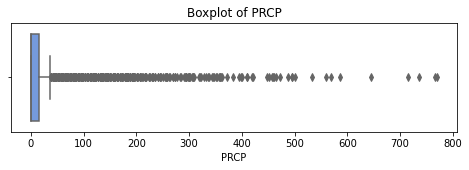

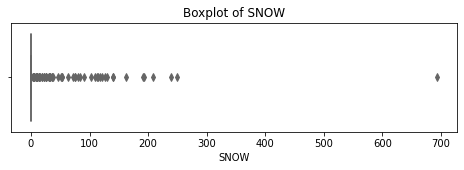

In [ ]:
# TODO:Will make more sense if we do it based on season/month/week
cols = ['TMAX','TMIN','PRCP', 'SNOW'] #'AWND','SNWD', 'WDF2', 'WDF5', 'WSF2',	'WSF5'
for col in cols:
    plt.figure(figsize=(8, 2))
    sns.boxplot(x=col,data=weather_features, color="cornflowerblue")
    plt.title('Boxplot of '+col)
    plt.show()


**Correlation analysis**

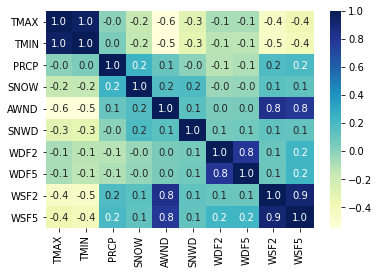

In [ ]:
sns.heatmap(weather_features.corr(), annot=True, fmt=".1f", cmap="YlGnBu");

In [ ]:
# TODO:Outlier/missing value treatment of weather data

**Ride data visualization**

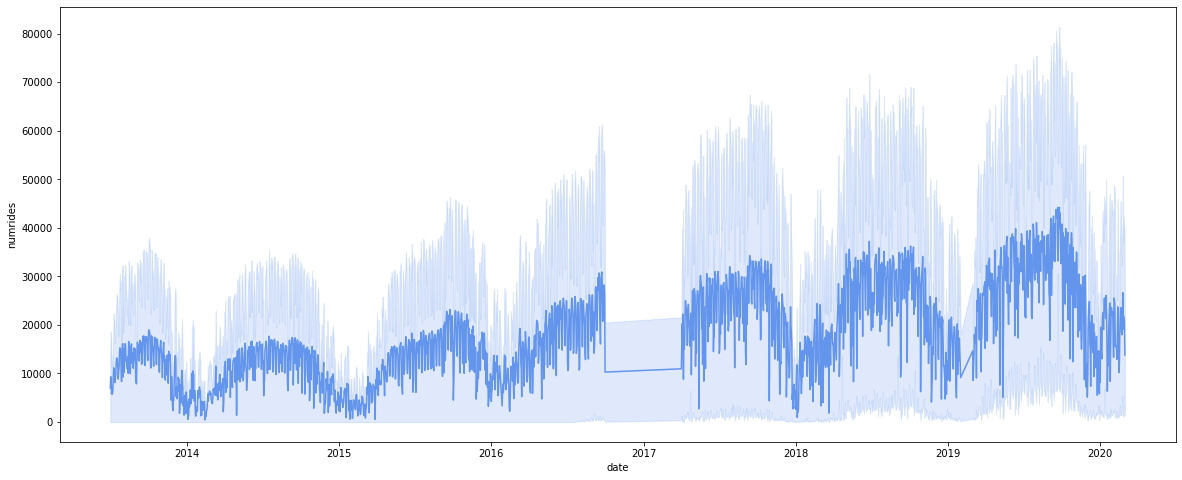

In [ ]:
plt.figure(figsize=(20,8))
sns.lineplot(data=rides,x='date', y='numrides', color="cornflowerblue")


In [ ]:
# TODO:Missing value analysis of ride data


**Outlier analysis of total ride count**

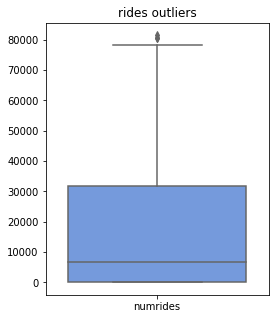

In [ ]:

fig,ax=plt.subplots(figsize=(4,5))
sns.boxplot(data=rides[['numrides']], color="cornflowerblue")
ax.set_title('rides outliers')
plt.show()

## Data integration
Merge ride data and weather data 


In [ ]:
rides = rides.merge(weather_features, left_on='date', right_on='Date').drop(['Date'], axis=1)
rides = rides.fillna(rides.mean())
rides.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  


,date,usertype,numrides,TMAX,TMIN,PRCP,SNOW,AWND,SNWD,WDF2,WDF5,WSF2,WSF5
0,2015-01-01,Customer,0,39.0,-27.0,0.0,0.0,32.0,0.0,260.0,250.0,76.0,139.0
1,2015-01-01,Subscriber,4651,39.0,-27.0,0.0,0.0,32.0,0.0,260.0,250.0,76.0,139.0
2,2015-01-02,Customer,0,56.0,17.0,0.0,0.0,32.0,0.0,260.0,310.0,67.0,112.0
3,2015-01-02,Subscriber,10662,56.0,17.0,0.0,0.0,32.0,0.0,260.0,310.0,67.0,112.0
4,2015-01-03,Customer,0,56.0,6.0,180.0,0.0,29.0,0.0,80.0,70.0,54.0,81.0


**Add new columns for day_of_week, week_of_year, month etc**


In [ ]:
rides['day_of_week'] = pd.DatetimeIndex(rides['date']).dayofweek
rides['week_of_year'] = pd.DatetimeIndex(rides['date']).week
rides['month'] = pd.DatetimeIndex(rides['date']).month        
rides['year'] = pd.DatetimeIndex(rides['date']).year
rides.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  


,date,usertype,numrides,TMAX,TMIN,PRCP,SNOW,AWND,SNWD,WDF2,WDF5,WSF2,WSF5,day_of_week,week_of_year,month,year
0,2015-01-01,Customer,0,39.0,-27.0,0.0,0.0,32.0,0.0,260.0,250.0,76.0,139.0,3,1,1,2015
1,2015-01-01,Subscriber,4651,39.0,-27.0,0.0,0.0,32.0,0.0,260.0,250.0,76.0,139.0,3,1,1,2015
2,2015-01-02,Customer,0,56.0,17.0,0.0,0.0,32.0,0.0,260.0,310.0,67.0,112.0,4,1,1,2015
3,2015-01-02,Subscriber,10662,56.0,17.0,0.0,0.0,32.0,0.0,260.0,310.0,67.0,112.0,4,1,1,2015
4,2015-01-03,Customer,0,56.0,6.0,180.0,0.0,29.0,0.0,80.0,70.0,54.0,81.0,5,1,1,2015


**Encoding the date fields into binary vectors**


In [ ]:
cols = ['day_of_week', 'week_of_year', 'month']
for col in cols:
    dummy_col = pd.get_dummies(rides[col], prefix=col, drop_first=False)
    rides = pd.concat([rides, dummy_col], axis=1)

rides = rides.drop(cols, axis=1)
rides.head()

,date,usertype,numrides,TMAX,TMIN,PRCP,SNOW,AWND,SNWD,WDF2,WDF5,WSF2,WSF5,year,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,week_of_year_1,week_of_year_2,week_of_year_3,week_of_year_4,week_of_year_5,week_of_year_6,week_of_year_7,week_of_year_8,week_of_year_9,week_of_year_10,week_of_year_11,week_of_year_12,week_of_year_13,week_of_year_14,week_of_year_15,week_of_year_16,week_of_year_17,week_of_year_18,week_of_year_19,...,week_of_year_26,week_of_year_27,week_of_year_28,week_of_year_29,week_of_year_30,week_of_year_31,week_of_year_32,week_of_year_33,week_of_year_34,week_of_year_35,week_of_year_36,week_of_year_37,week_of_year_38,week_of_year_39,week_of_year_40,week_of_year_41,week_of_year_42,week_of_year_43,week_of_year_44,week_of_year_45,week_of_year_46,week_of_year_47,week_of_year_48,week_of_year_49,week_of_year_50,week_of_year_51,week_of_year_52,week_of_year_53,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,2015-01-01,Customer,0,39.0,-27.0,0.0,0.0,32.0,0.0,260.0,250.0,76.0,139.0,2015,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,2015-01-01,Subscriber,4651,39.0,-27.0,0.0,0.0,32.0,0.0,260.0,250.0,76.0,139.0,2015,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,2015-01-02,Customer,0,56.0,17.0,0.0,0.0,32.0,0.0,260.0,310.0,67.0,112.0,2015,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,2015-01-02,Subscriber,10662,56.0,17.0,0.0,0.0,32.0,0.0,260.0,310.0,67.0,112.0,2015,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,2015-01-03,Customer,0,56.0,6.0,180.0,0.0,29.0,0.0,80.0,70.0,54.0,81.0,2015,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


**Separating data into subscriber and customer datasets**

In [ ]:
subscriber_rides = rides[rides['usertype'] == 'Subscriber']
customer_rides = rides[(rides['usertype'] == 'Customer') & (rides['date'] >= '2016-01-01')]

subscriber_rides.head()

,date,usertype,numrides,TMAX,TMIN,PRCP,SNOW,AWND,SNWD,WDF2,WDF5,WSF2,WSF5,year,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,week_of_year_1,week_of_year_2,week_of_year_3,week_of_year_4,week_of_year_5,week_of_year_6,week_of_year_7,week_of_year_8,week_of_year_9,week_of_year_10,week_of_year_11,week_of_year_12,week_of_year_13,week_of_year_14,week_of_year_15,week_of_year_16,week_of_year_17,week_of_year_18,week_of_year_19,...,week_of_year_26,week_of_year_27,week_of_year_28,week_of_year_29,week_of_year_30,week_of_year_31,week_of_year_32,week_of_year_33,week_of_year_34,week_of_year_35,week_of_year_36,week_of_year_37,week_of_year_38,week_of_year_39,week_of_year_40,week_of_year_41,week_of_year_42,week_of_year_43,week_of_year_44,week_of_year_45,week_of_year_46,week_of_year_47,week_of_year_48,week_of_year_49,week_of_year_50,week_of_year_51,week_of_year_52,week_of_year_53,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
1,2015-01-01,Subscriber,4651,39.0,-27.0,0.0,0.0,32.0,0.0,260.0,250.0,76.0,139.0,2015,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,2015-01-02,Subscriber,10662,56.0,17.0,0.0,0.0,32.0,0.0,260.0,310.0,67.0,112.0,2015,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
5,2015-01-03,Subscriber,4252,56.0,6.0,180.0,0.0,29.0,0.0,80.0,70.0,54.0,81.0,2015,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
7,2015-01-04,Subscriber,7456,133.0,50.0,76.0,0.0,29.0,0.0,280.0,260.0,130.0,206.0,2015,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
9,2015-01-05,Subscriber,14256,94.0,-60.0,0.0,0.0,47.0,0.0,280.0,300.0,107.0,170.0,2015,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


# Bike Ride Forecasting

**Find test train split date**

Subscriber data is selected for modeling

Latest 365 days is selected for testing

In [ ]:
holdout_period = 365
max_date = subscriber_rides[['date']].max()
split_date = max_date - timedelta(days=holdout_period)
split_date = split_date[0].strftime('%Y-%m-%d')
print(split_date)

2019-03-01


In [ ]:
split_date

'2019-03-01'

In [ ]:
# Split Date into 180 days
holdout_period = 180
max_date = subscriber_rides[['date']].max()
six_month_date = max_date - timedelta(days=holdout_period)
six_month_date = six_month_date[0].strftime('%Y-%m-%d')
print(six_month_date)

2019-09-02


In [ ]:
six_month_date

'2019-09-02'

**Train and test data split**

In [ ]:
# Test set 1 year
X0 = subscriber_rides.drop(['date','usertype', 'year', 'numrides'], axis=1)
y0 = subscriber_rides['numrides']
train = subscriber_rides.loc[subscriber_rides.date <= split_date].copy()
test = subscriber_rides.loc[subscriber_rides.date > split_date].copy()
X0_train = train.drop(['date','usertype', 'year', 'numrides'], axis=1)
y0_train = train['numrides']
X0_test = test.drop(['date','usertype', 'year', 'numrides'], axis=1)
y0_test = test['numrides']

In [ ]:
y0_test

2615    16521
2617    20945
2619    26751
2621    35293
2623    31940
        ...  
3335    37032
3337    42252
3339    40628
3341    39944
3343    25795
Name: numrides, Length: 365, dtype: int64

In [ ]:
# Test set 180 days 
X1 = subscriber_rides.drop(['date','usertype', 'year', 'numrides'], axis=1)
y1 = subscriber_rides['numrides']
train = subscriber_rides.loc[subscriber_rides.date <= six_month_date].copy()
test = subscriber_rides.loc[subscriber_rides.date > six_month_date].copy()
X_train = train.drop(['date','usertype', 'year', 'numrides'], axis=1)
y_train = train['numrides']
X_test = test.drop(['date','usertype', 'year', 'numrides'], axis=1)
y_test = test['numrides']

In [ ]:
y_test

2985    71470
2987    74206
2989    77438
2991    48912
2993    55912
        ...  
3335    37032
3337    42252
3339    40628
3341    39944
3343    25795
Name: numrides, Length: 180, dtype: int64

**Linear Regression** 

In [ ]:
# Linear Regression for 1year
model0 = LinearRegression()

# Train the model using the training sets
model0.fit(X0_train, y0_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
# Linear Regression for 180days
model = LinearRegression()

# Fit to the data
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

### Prediction 1year and 180 days

In [ ]:
# Predicting # of rides given date/weather features (1year)
y_pred0 = model0.predict(X0_test)

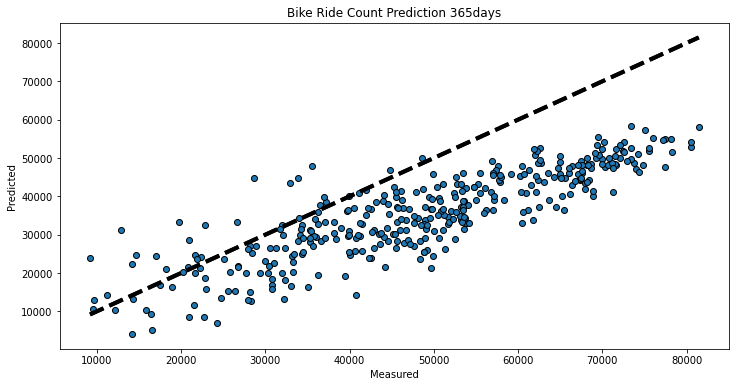

In [ ]:
# Plot Prediction for (365 days)
fig, ax = plt.subplots(figsize=(12,6))
ax.scatter(y0_test, y_pred0, edgecolors=(0, 0, 0))
ax.plot([y0_test.min(), y0_test.max()], [y0_test.min(), y0_test.max()], 'k--', lw=4)
ax.plot([y0_test.min(), y0_test.max()], [y0_test.min(), y0_test.max()], 'k--', lw=4)
ax.set_title('Bike Ride Count Prediction 365days')
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [ ]:
# Predicting # of rides given date/weather features (180days)
y_pred = model.predict(X_test)

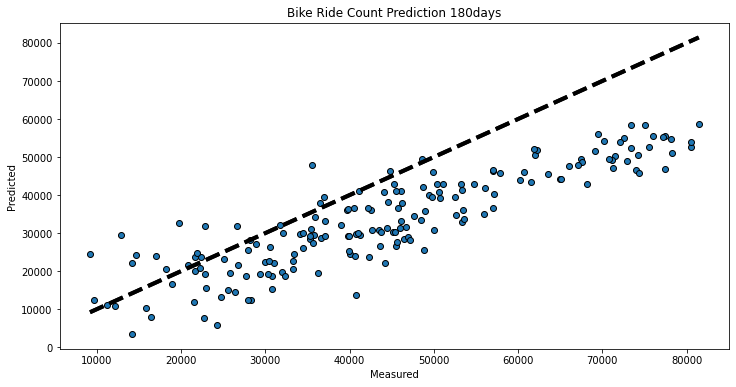

In [ ]:
# Plot Prediction for (180 days) 
fig, ax = plt.subplots(figsize=(12,6))
ax.scatter(y_test, y_pred, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_title('Bike Ride Count Prediction 180days')
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

### Cross Validation

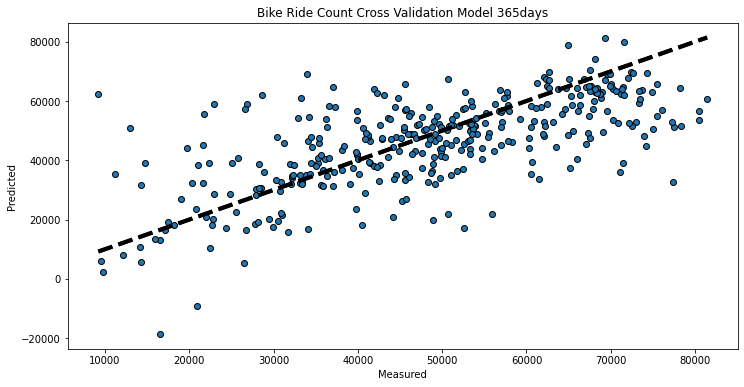

In [ ]:
# Cross validation 1year
fig, ax = plt.subplots(figsize=(12,6))
predicted = cross_val_predict(model0, X0_test, y0_test, cv=10)

ax.scatter(y0_test, predicted, edgecolors=(0, 0, 0))
ax.plot([y0_test.min(), y0_test.max()], [y0_test.min(), y0_test.max()], 'k--', lw=4)
ax.plot([y0_test.min(), y0_test.max()], [y0_test.min(), y0_test.max()], 'k--', lw=4)
ax.set_title('Bike Ride Count Cross Validation Model 365days')
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')

plt.show()

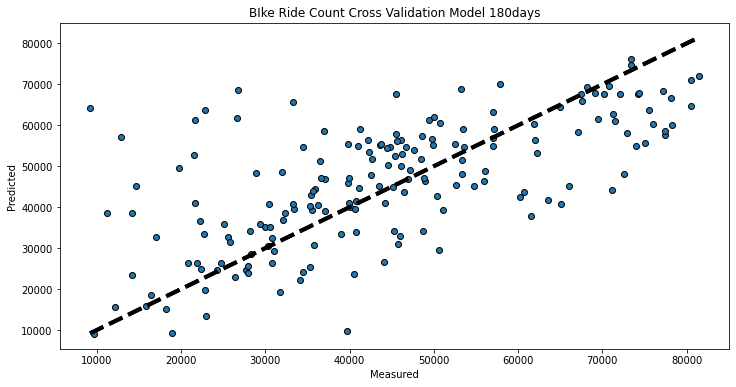

In [ ]:
# Cross validation 180days
fig, ax = plt.subplots(figsize=(12,6))
predicted = cross_val_predict(model, X_test, y_test, cv=10)

ax.scatter(y_test, predicted, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_title('BIke Ride Count Cross Validation Model 180days')
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

##Model evaluation 1year

In [ ]:
# Metric Evaluation Results for 365 days
scores = cross_val_score(model0, X0_test, y0_test, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

# The coefficients
print('Coefficients: \n', model0.coef_)

print('R square: %.3f' % r2_score(y0_test, y_pred0))
print('MSE:', metrics.mean_squared_error(y0_test, y_pred0))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y0_test, y_pred0)))
print('MAE:', mean_absolute_error(y0_test, y_pred0))
print('MAPE:', np.mean(np.abs((y0_test - y_pred0) / y0_test)))
print('MDAPE:', np.median(np.abs((y0_test - y_pred0) / y0_test))) 

Accuracy: -0.26 (+/- 2.00)
Coefficients: 
 [ 2.12921202e+01  8.27504768e+00 -3.67656885e+01 -3.48189027e+01
 -2.77642975e+02 -5.82577305e+01 -3.99727098e+00  6.00446978e+00
 -3.50969051e+01  3.33334551e+01  1.20725866e+03  4.34137783e+03
  5.20912441e+03  4.59766333e+03  2.41640916e+03 -7.94529233e+03
 -9.82654106e+03 -9.78821218e+03 -7.84899870e+03 -8.29354330e+03
 -8.18103468e+03 -5.80551959e+03 -5.35192714e+03 -2.61570927e+03
 -2.20480008e+03  4.20020736e+03  8.23913652e+03  4.42610067e+03
  2.40013379e+03 -4.33066460e+02 -2.46014236e+03  1.18563783e+03
  3.82880267e+03  1.87144681e+03  2.06741437e+03  8.55702061e+02
  2.69207004e+02 -2.43570296e+03 -3.12211889e+03 -3.78149770e+03
 -4.00086115e+03 -3.60561987e+03 -3.34529610e+03 -3.36687001e+03
  3.22486028e+03  3.94648570e+03  2.29663652e+03  3.60916165e+03
  2.05500263e+03  1.98551445e+03  4.68760714e+03  2.66386509e+03
  6.39051334e+03  1.10433296e+04  1.29873983e+04  1.38761226e+04
  1.11571384e+04  9.26061872e+03  1.09473113e+0

In [ ]:
# y0_test

In [ ]:
# Metric Evaluation Results for 180 days
scores = cross_val_score(model, X_test, y_test, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

# The coefficients
print('Coefficients: \n', model.coef_)

print('R square: %.3f' % r2_score(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('MAE:', mean_absolute_error(y_test, y_pred))
print('MAPE:', np.mean(np.abs((y_test - y_pred) / y_test)))
print('MDAPE:', np.median(np.abs((y_test - y_pred) / y_test))) 

Accuracy: -1.12 (+/- 6.48)
Coefficients: 
 [ 2.75342664e+01 -1.56421853e-01 -3.81261718e+01 -3.17921058e+01
 -3.26755459e+02 -6.06653898e+01 -4.21051136e+00  3.80981603e+00
 -6.65489850e+01  5.77768787e+01  1.24330058e+03  4.58026119e+03
  5.39826615e+03  4.48205478e+03  2.50874852e+03 -7.97905938e+03
 -1.02335718e+04 -1.28479401e+04 -1.09818137e+04 -1.14339773e+04
 -1.13517852e+04 -9.32453331e+03 -9.04297254e+03 -6.41025881e+03
 -5.84445515e+03  1.03255598e+02  2.79033521e+03  2.42910347e+03
 -4.45498812e+02 -1.42147330e+03 -2.35595899e+03  1.06144348e+03
  2.07019229e+03  4.81541962e+02  1.60980206e+03  1.49128365e+03
  4.58977883e+02 -8.86329024e+02 -2.01488072e+03 -1.27288658e+03
 -2.59524468e+03 -3.24938699e+03 -1.79799738e+03 -1.81480512e+03
  6.00149109e+03  6.01913993e+03  5.49564198e+03  7.17633653e+03
  6.13144416e+03  5.95535906e+03  8.04834451e+03  6.99847136e+03
  8.31690260e+03  1.35782172e+04  1.54946379e+04  1.65153073e+04
  1.26542391e+04  1.03312450e+04  1.19586015e+0

**Feature importances**

**Actual vs Observed values**

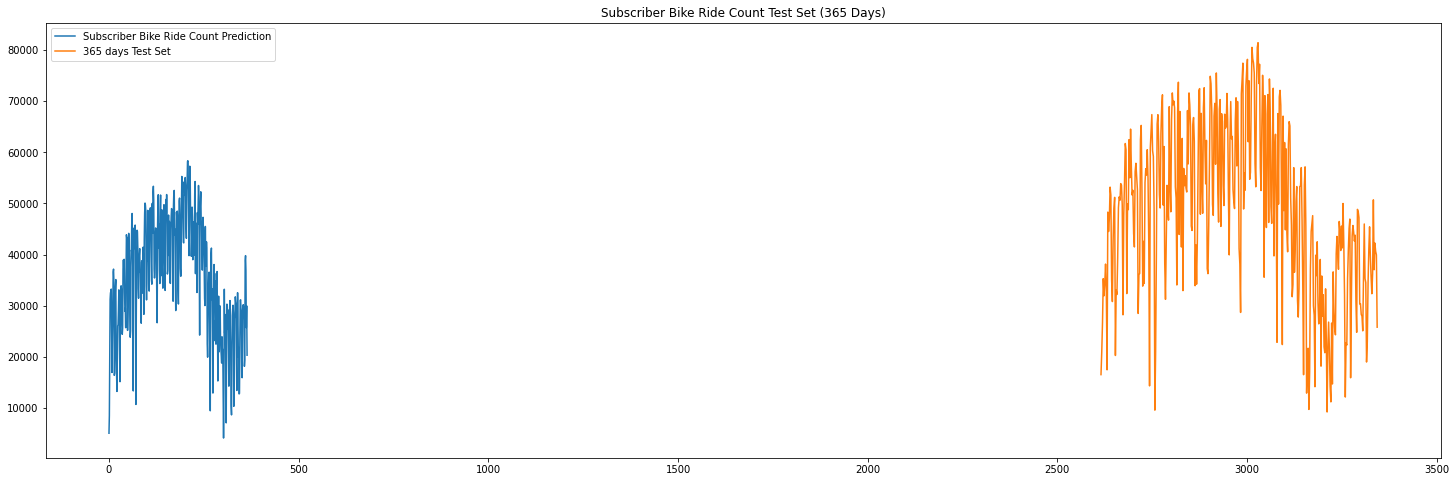

In [ ]:
fig, ax = plt.subplots(figsize=(25,8))
ax.plot(y_pred0, label='Subscriber Bike Ride Count Prediction')
ax.plot(y0_test,label='365 days Test Set')
plt.title('Subscriber Bike Ride Count Test Set (365 Days)')
ax.legend()

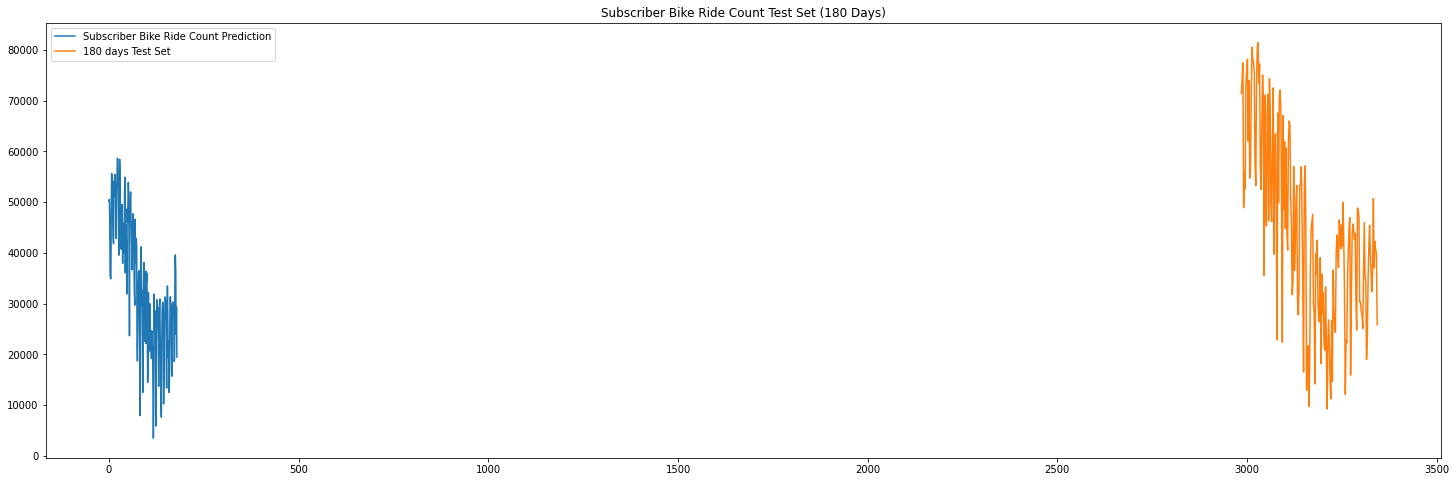

In [ ]:
fig, ax = plt.subplots(figsize=(25,8))
ax.plot(y_pred, label='Subscriber Bike Ride Count Prediction')
ax.plot(y_test,label='180 days Test Set')
plt.title('Subscriber Bike Ride Count Test Set (180 Days)')
ax.legend()

# Investigate rider age and gender effects on bike ridership and bike ride duration

## Data preprocessing

In [ ]:
rides_tmp = []
years = range(2017, 2021)
for y in years:
  rides_y = pd.read_csv('/content/drive/My Drive/cmpe-255 - Data Mining/citibikes/rides_{}.csv'.format(y), index_col=0)
  rides_tmp.append(rides_y)

rides = pd.concat(rides_tmp)

/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [ ]:
rides.reset_index(level=0, inplace=True)
rides.dropna(subset=['birth year', 'gender'])

,tripduration,date,usertype,birth year,gender
0,195,2017-04-01,Subscriber,1966.0,1.0
1,585,2017-04-01,Subscriber,1995.0,1.0
2,665,2017-04-01,Subscriber,1987.0,1.0
3,262,2017-04-01,Subscriber,1961.0,1.0
4,134,2017-04-01,Subscriber,1967.0,2.0
...,...,...,...,...,...
61336812,1111,2020-08-31,Subscriber,1994.0,2.0
61336813,1562,2020-08-31,Customer,2001.0,1.0
61336814,1023,2020-08-31,Customer,1993.0,2.0
61336815,600,2020-08-31,Subscriber,2002.0,1.0


In [ ]:
rides.head()

In [ ]:
rides['birth year'] = 2020 - round(rides['birth year'])
rides['tripduration'] = round(rides['tripduration']/60, 2)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


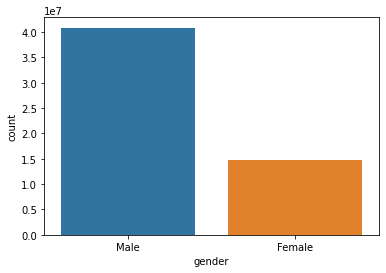

In [ ]:
# Count plot no of males and females
rides['gender'].value_counts()
splot = sns.countplot('gender', data=rides)
splot.axes.set_xticklabels(['Male', 'Female'])
plt.show()

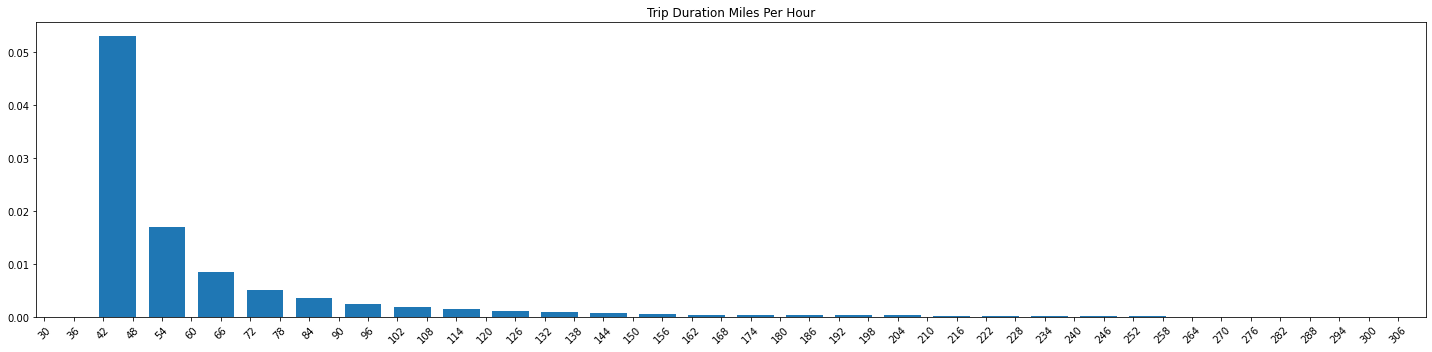

In [ ]:
fig, axs = plt.subplots(figsize=(20,5))
bins = [40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300]

axs.hist(rides['tripduration'], bins, density=True, histtype='bar', rwidth=0.75)
axs.set_title('Trip Duration Miles Per Hour')
axs.xaxis.set_major_locator(plt.MaxNLocator(52))
plt.xticks(rotation=45)
fig.tight_layout()
plt.show()

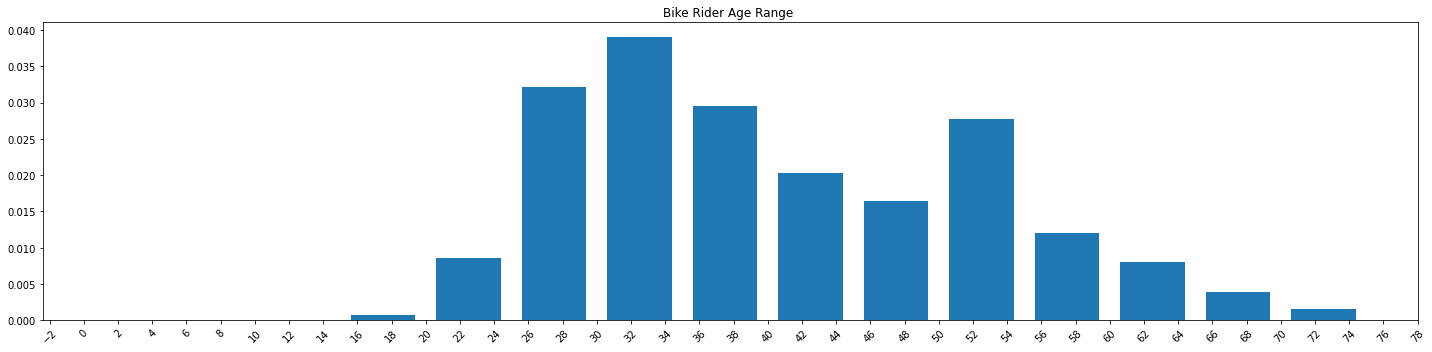

In [ ]:
fig, axs = plt.subplots(figsize=(20,5))
bins = [0, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75]

axs.hist(rides['birth year'], bins, density=True, histtype='bar', rwidth=0.75)
axs.set_title('Bike Rider Age Range ')
axs.xaxis.set_major_locator(plt.MaxNLocator(52))
plt.xticks(rotation=45)
fig.tight_layout()
plt.show()

## Data integration
Merge number of crashes data and weather data 

In [ ]:
rides = rides.merge(weather_features, left_on='date', right_on='Date').drop(['Date'], axis=1)
rides = rides.fillna(rides.mean())
rides.head()

# Bike Accident Forecasting

In [ ]:
path = '/content/drive/My Drive/CMPE 255 Project/data/bike_accidents/accident_count_agg.csv'
num_bike_collisions = pd.read_csv(path)
num_bike_collisions['date'] = pd.to_datetime(num_bike_collisions['date'], infer_datetime_format=True)
num_bike_collisions

,date,num_crashes
0,2016-03-08,2
1,2016-03-09,1
2,2016-03-11,1
3,2016-03-12,2
4,2016-03-13,5
...,...,...
1674,2020-10-09,27
1675,2020-10-10,13
1676,2020-10-11,17
1677,2020-10-12,13


In [ ]:
num_bike_collisions = num_bike_collisions.merge(weather_features, left_on='date', right_on='Date').drop(['Date'], axis=1)
num_bike_collisions = num_bike_collisions.fillna(num_bike_collisions.mean())
num_bike_collisions = num_bike_collisions.rename(columns={'date':'ds', 'num_crashes':'y'})
num_bike_collisions

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  


,ds,y,TMAX,TMIN,PRCP,SNOW,AWND,SNWD,WDF2,WDF5,WSF2,WSF5
0,2016-03-08,2,194.0,83.0,0.0,0.0,15.00000,0.0,170.000000,170.000000,63.00000,85.000000
1,2016-03-09,1,250.0,67.0,0.0,0.0,10.00000,0.0,240.000000,210.000000,45.00000,98.000000
2,2016-03-11,1,200.0,89.0,15.0,0.0,27.00000,0.0,40.000000,10.000000,76.00000,116.000000
3,2016-03-12,2,150.0,44.0,0.0,0.0,23.00000,0.0,250.000000,250.000000,67.00000,103.000000
4,2016-03-13,5,167.0,100.0,0.0,0.0,16.00000,0.0,30.000000,30.000000,54.00000,81.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
1662,2020-09-27,31,261.0,194.0,8.0,0.0,22.07978,0.0,191.894231,194.937111,60.57761,98.586731
1663,2020-09-28,23,250.0,206.0,5.0,0.0,22.07978,0.0,191.894231,194.937111,60.57761,98.586731
1664,2020-09-29,21,233.0,194.0,119.0,0.0,22.07978,0.0,191.894231,194.937111,60.57761,98.586731
1665,2020-09-30,27,217.0,156.0,290.0,0.0,28.00000,0.0,270.000000,160.000000,76.00000,121.000000


In [ ]:
holdout_period = 365
max_date = num_bike_collisions[['ds']].max()
split_date = max_date - timedelta(days=holdout_period)
split_date = split_date[0].strftime('%Y-%m-%d')
train = num_bike_collisions.loc[num_bike_collisions.ds <= split_date].copy()
test = num_bike_collisions.loc[num_bike_collisions.ds > split_date].copy()
print(split_date)

2019-10-02


In [ ]:
# Split Date into 180 days
holdout_period = 180
max_date = num_bike_collisions[['ds']].max()
six_month_date = max_date - timedelta(days=holdout_period)
six_month_date = six_month_date[0].strftime('%Y-%m-%d')
train = num_bike_collisions.loc[num_bike_collisions.ds <= split_date].copy()
test = num_bike_collisions.loc[num_bike_collisions.ds > split_date].copy()
print(six_month_date)

2020-04-04


**Train and test data split**

In [ ]:
# Test set 1 year
X0 = num_bike_collisions.drop(['ds','y'], axis=1)
y0 = num_bike_collisions['y']
train = num_bike_collisions.loc[num_bike_collisions.ds <= split_date].copy()
test = num_bike_collisions.loc[num_bike_collisions.ds > split_date].copy()
X0_train = train.drop(['ds', 'y'], axis=1)
y0_train = train['y']
X0_test = test.drop(['ds', 'y'], axis=1)
y0_test = test['y']

In [ ]:
# Test set 180 days 
X1 = num_bike_collisions.drop(['ds', 'y'], axis=1)
y1 = num_bike_collisions['y']
train = num_bike_collisions.loc[num_bike_collisions.ds <= six_month_date].copy()
test = num_bike_collisions.loc[num_bike_collisions.ds > six_month_date].copy()
X_train = train.drop(['ds', 'y'], axis=1)
y_train = train['y']
X_test = test.drop(['ds', 'y'], axis=1)
y_test = test['y']

**Linear Regression**

In [ ]:
# Linear Regression for 1year
model0 = LinearRegression()

# Train the model using the training sets
model0.fit(X0_train, y0_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
# Linear Regression for 180days
model = LinearRegression()

# Fit to the data
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

### Prediction 1year and 180 days

In [ ]:
# Predicting # of collision given date/weather features (1year)
y_pred0 = model0.predict(X0_test)

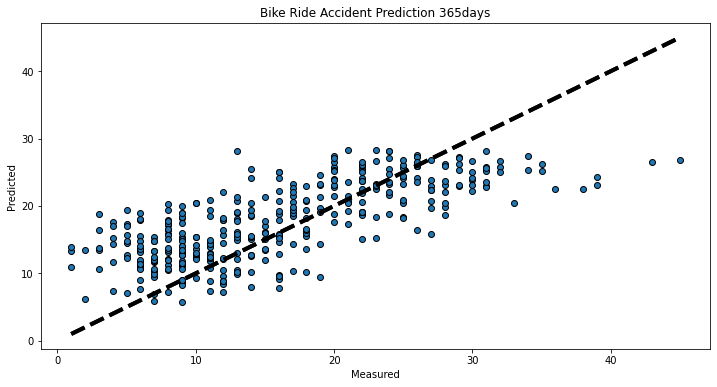

In [ ]:
# Plot Prediction for (365 days) 
fig, ax = plt.subplots(figsize=(12,6))
ax.scatter(y0_test, y_pred0, edgecolors=(0, 0, 0))
ax.plot([y0_test.min(), y0_test.max()], [y0_test.min(), y0_test.max()], 'k--', lw=4)
ax.plot([y0_test.min(), y0_test.max()], [y0_test.min(), y0_test.max()], 'k--', lw=4)
ax.set_title('Bike Ride Accident Prediction 365days')
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [ ]:
# Predicting # of collision given date/weather features (180days)
y_pred = model.predict(X_test)

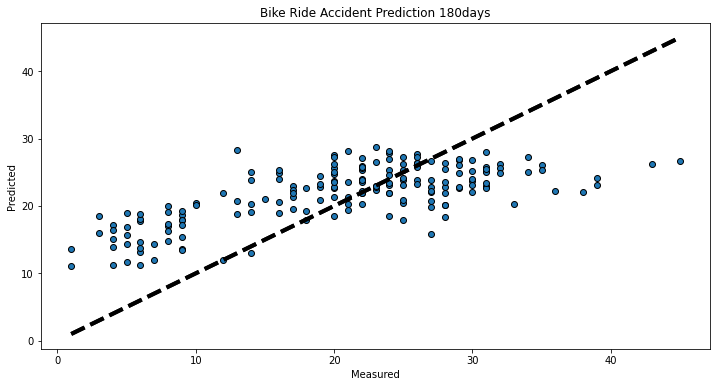

In [ ]:
# Plot Prediction for (180 days) 
fig, ax = plt.subplots(figsize=(12,6))
ax.scatter(y_test, y_pred, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_title('Bike Ride Accident Prediction 180days')
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

### Cross Validation

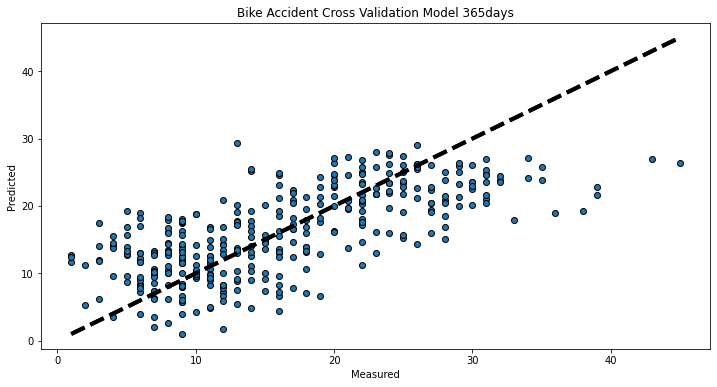

In [ ]:
# Cross validation 1year
fig, ax = plt.subplots(figsize=(12,6))
predicted = cross_val_predict(model0, X0_test, y0_test, cv=10)

ax.scatter(y0_test, predicted, edgecolors=(0, 0, 0))
ax.plot([y0_test.min(), y0_test.max()], [y0_test.min(), y0_test.max()], 'k--', lw=4)
ax.plot([y0_test.min(), y0_test.max()], [y0_test.min(), y0_test.max()], 'k--', lw=4)
ax.set_title('Bike Accident Cross Validation Model 365days')
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')

plt.show()

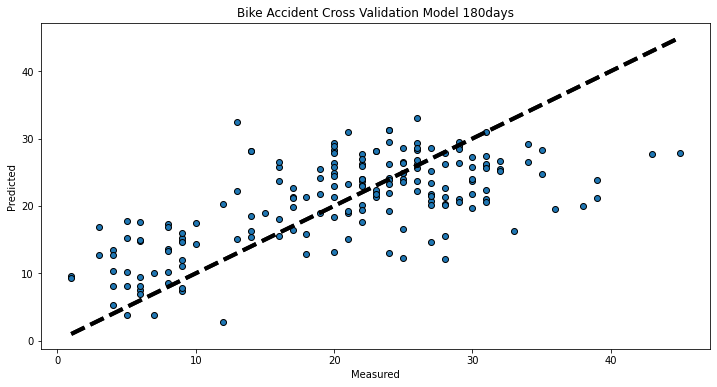

In [ ]:
# Cross validation 180days
fig, ax = plt.subplots(figsize=(12,6))
predicted = cross_val_predict(model, X_test, y_test, cv=10)

ax.scatter(y_test, predicted, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_title('Bike Accident Cross Validation Model 180days')
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

##Model evaluation 1year and 180days

In [ ]:
# Metric Evaluation Results for 365 days
scores = cross_val_score(model0, X0_test, y0_test, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

# The coefficients
print('Coefficients: \n', model0.coef_)

print('R square: %.3f' % r2_score(y0_test, y_pred0))
print('MSE:', metrics.mean_squared_error(y0_test, y_pred0))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y0_test, y_pred0)))
print('MAE:', mean_absolute_error(y0_test, y_pred0))
print('MAPE:', np.mean(np.abs((y0_test - y_pred0) / y0_test)))
print('MDAPE:', np.median(np.abs((y0_test - y_pred0) / y0_test))) 

Accuracy: -0.75 (+/- 2.24)
Coefficients: 
 [ 0.05080682  0.00970133 -0.01576994 -0.0037663   0.04928738 -0.01707028
 -0.0025146   0.00324431 -0.01573711 -0.01909236]
R square: 0.495
MSE: 37.458676741521195
RMSE: 6.12034939701331
MAE: 4.921544208174746
MAPE: 0.5930975478167413
MDAPE: 0.26196703885306505


In [ ]:
# y0_test

In [ ]:
# Metric Evaluation Results for 180 days
scores = cross_val_score(model, X_test, y_test, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

# The coefficients
print('Coefficients: \n', model.coef_)

print('R square: %.3f' % r2_score(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('MAE:', mean_absolute_error(y_test, y_pred))
print('MAPE:', np.mean(np.abs((y_test - y_pred) / y_test)))
print('MDAPE:', np.median(np.abs((y_test - y_pred) / y_test))) 

Accuracy: -1.41 (+/- 5.22)
Coefficients: 
 [ 0.04994491  0.0112093  -0.01513007 -0.00167843  0.03267723 -0.01361043
 -0.00142394  0.00297724 -0.02612033 -0.00980654]
R square: 0.418
MSE: 50.72109349647192
RMSE: 7.121874296592992
MAE: 5.80985909630715
MAPE: 0.6306899672267924
MDAPE: 0.22538940807250357


**Feature importances**

**Actual vs Observed values**

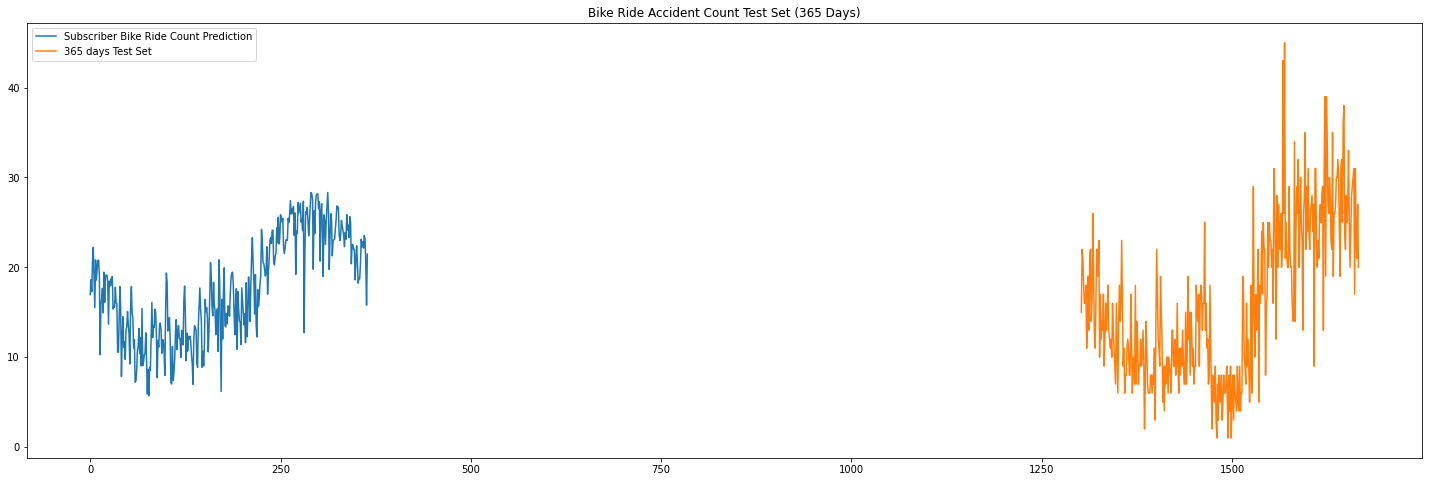

In [ ]:
fig, ax = plt.subplots(figsize=(25,8))
ax.plot(y_pred0, label='Subscriber Bike Ride Count Prediction')
ax.plot(y0_test,label='365 days Test Set')
plt.title('Bike Ride Accident Count Test Set (365 Days)')
ax.legend()

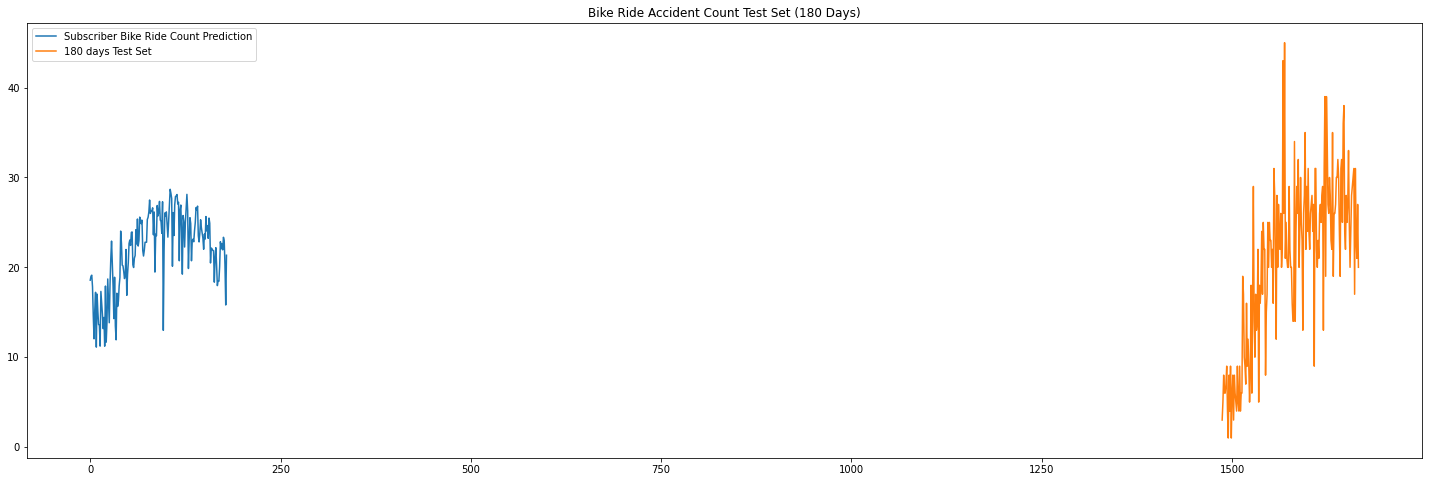

In [ ]:
fig, ax = plt.subplots(figsize=(25,8))
ax.plot(y_pred, label='Subscriber Bike Ride Count Prediction')
ax.plot(y_test,label='180 days Test Set')
plt.title('Bike Ride Accident Count Test Set (180 Days)')
ax.legend()